Time Series Forecasting (Research Lab,2023)

Rossmann Store Sales Forecast 

Rossmann operates over 3,000 drugstores in 7 European countries. Currently, Rossmann store managers have to forecast their daily sales up to six weeks in advance. Store sales are influenced by many factors, such as promotions, competition, school and public holidays, seasonal and local conditions. Because thousands of store managers forecast sales based on their individual circumstances, the accuracy of results can vary widely. This booklet focuses primarily on time series analysis (seasonal decomposition, trends, autocorrelation).

Steps to be performed

1.Data pre-processing and cleaning                                                                                               
2.Visualize the data                                                                                                             
3.Make the time series data stationary, if required                                                                             
4.Plot correlation and auto-correlation charts                                                                                   
5.Selection of the parameters and building of model for the plotting                                                             
6.Use the model to make the required predictions 

In [1]:
#!pip install xgboost
#!pip install pmdarima

In [1]:
#!pip install fbprophet

In [1]:
# importing all the required libraries

#for data manipulation and calculations
import numpy as np
import pandas as pd
from datetime import datetime
from time import time

#for data plotting and visualizations
import matplotlib.pyplot as plt 
import seaborn as sns
#matplotlib inline
import itertools
from scipy import stats

#for time series analysis
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# prophet by Facebook
#from fbprophet import Prophet
from prophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

Dataset

I have taken the dataset of Rossman Stores sales data from the Kaggle website. The dataset included 3 csv files, store.csv, train.csv and test.csv.
Using the train.csv and test.csv, the model can be trained to perform the required predictions. 
Additional store.csv is given to work upon the feature selection and to check whether the data is stationary or not.

Link for the dataset - https://www.kaggle.com/competitions/rossmann-store-sales/data

In [2]:
#importing training dataset

train = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/train.csv")
test = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/test.csv")
store = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/store.csv")

In [3]:
train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

EXPLORATORY DATA ANALYSIS (EDA) on the given dataset:

To perform data cleaning, data pre-processing, checking the sales trend that vary with different factors.

In [4]:
display(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [5]:
display(test.isnull().sum())

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [6]:
display(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [7]:
display(test[pd.isnull(test.Open)])

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [8]:
# replacing the null values with 1
test.fillna(1, inplace=True)

In [9]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

In [10]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

<AxesSubplot:title={'center':'Store1'}, xlabel='Date'>

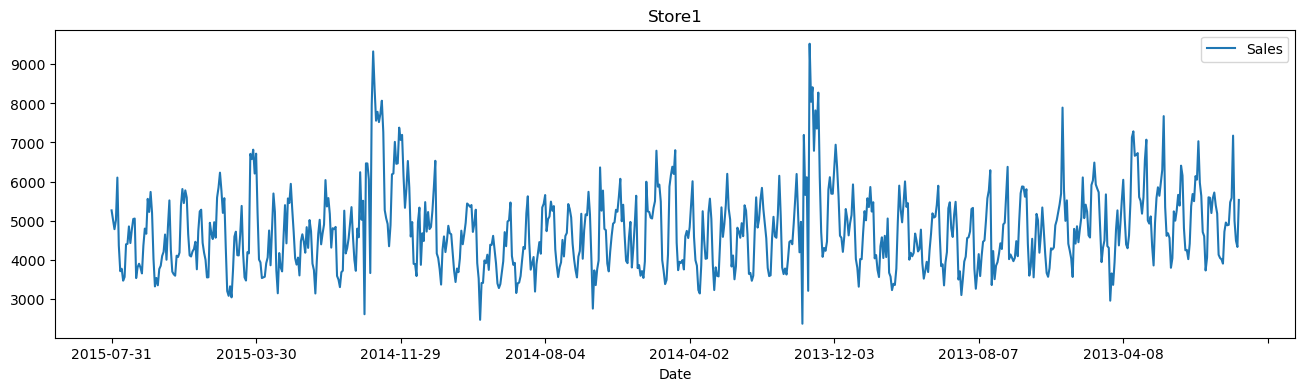

In [11]:
# sales of store1

strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

From the above chart, it is visible that the sales value for stores is achieving a peak during the month of December every year and there is a little spike during April and May. Both these duration, we can witness a jump in the sales as compared to other months.

Text(0.5, 1.0, 'Empirical Distribution of Sales')

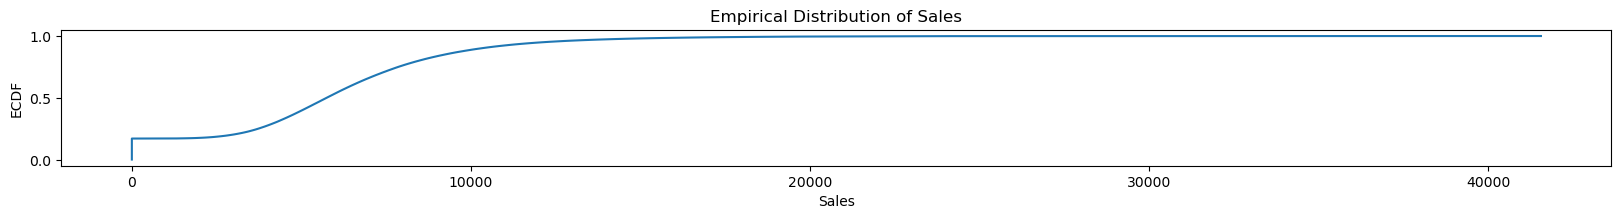

In [12]:
#as in above diagram it can be seen that data is not clearly distributed when plotted against the store data. Therefore the cummulative distribution fucntion is used to arrange the scale.

plt.figure(figsize = (20, 6))
plt.subplot(313)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('Sales');
plt.ylabel('ECDF');
plt.title("Empirical Distribution of Sales")

In [13]:
# for working with the Sarima Model

train1 = train
train2 = pd.merge(train1, store, on='Store')   

# for working with the Xgboost model

df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

In [14]:
#combining the two features to create a new feature that describes average sales per customer

train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2.shape

(1017209, 19)

In [15]:
def features_create(data):
    
    data['Date'] = pd.to_datetime(data['Date'])

    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [16]:
features_create(df_train_store)
features_create(df_test_store)
features_create(train2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,,9.482883,2015,7,31,31,82.0,24187.75,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1,3,...,,9.194139,2015,7,30,31,82.0,24187.75,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1,3,...,,9.143403,2015,7,29,31,82.0,24187.75,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1,3,...,,8.948214,2015,7,28,31,82.0,24187.75,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1,3,...,,9.970588,2015,7,27,31,82.0,24187.75,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5,2013-01-05,4771,339,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",14.073746,2013,1,5,1,24157.0,6.75,Jan,0
1017205,1115,4,2013-01-04,4540,326,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",13.926380,2013,1,4,1,24157.0,6.75,Jan,0
1017206,1115,3,2013-01-03,4297,300,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",14.323333,2013,1,3,1,24157.0,6.75,Jan,0
1017207,1115,2,2013-01-02,3697,305,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",12.121311,2013,1,2,1,24157.0,6.75,Jan,0


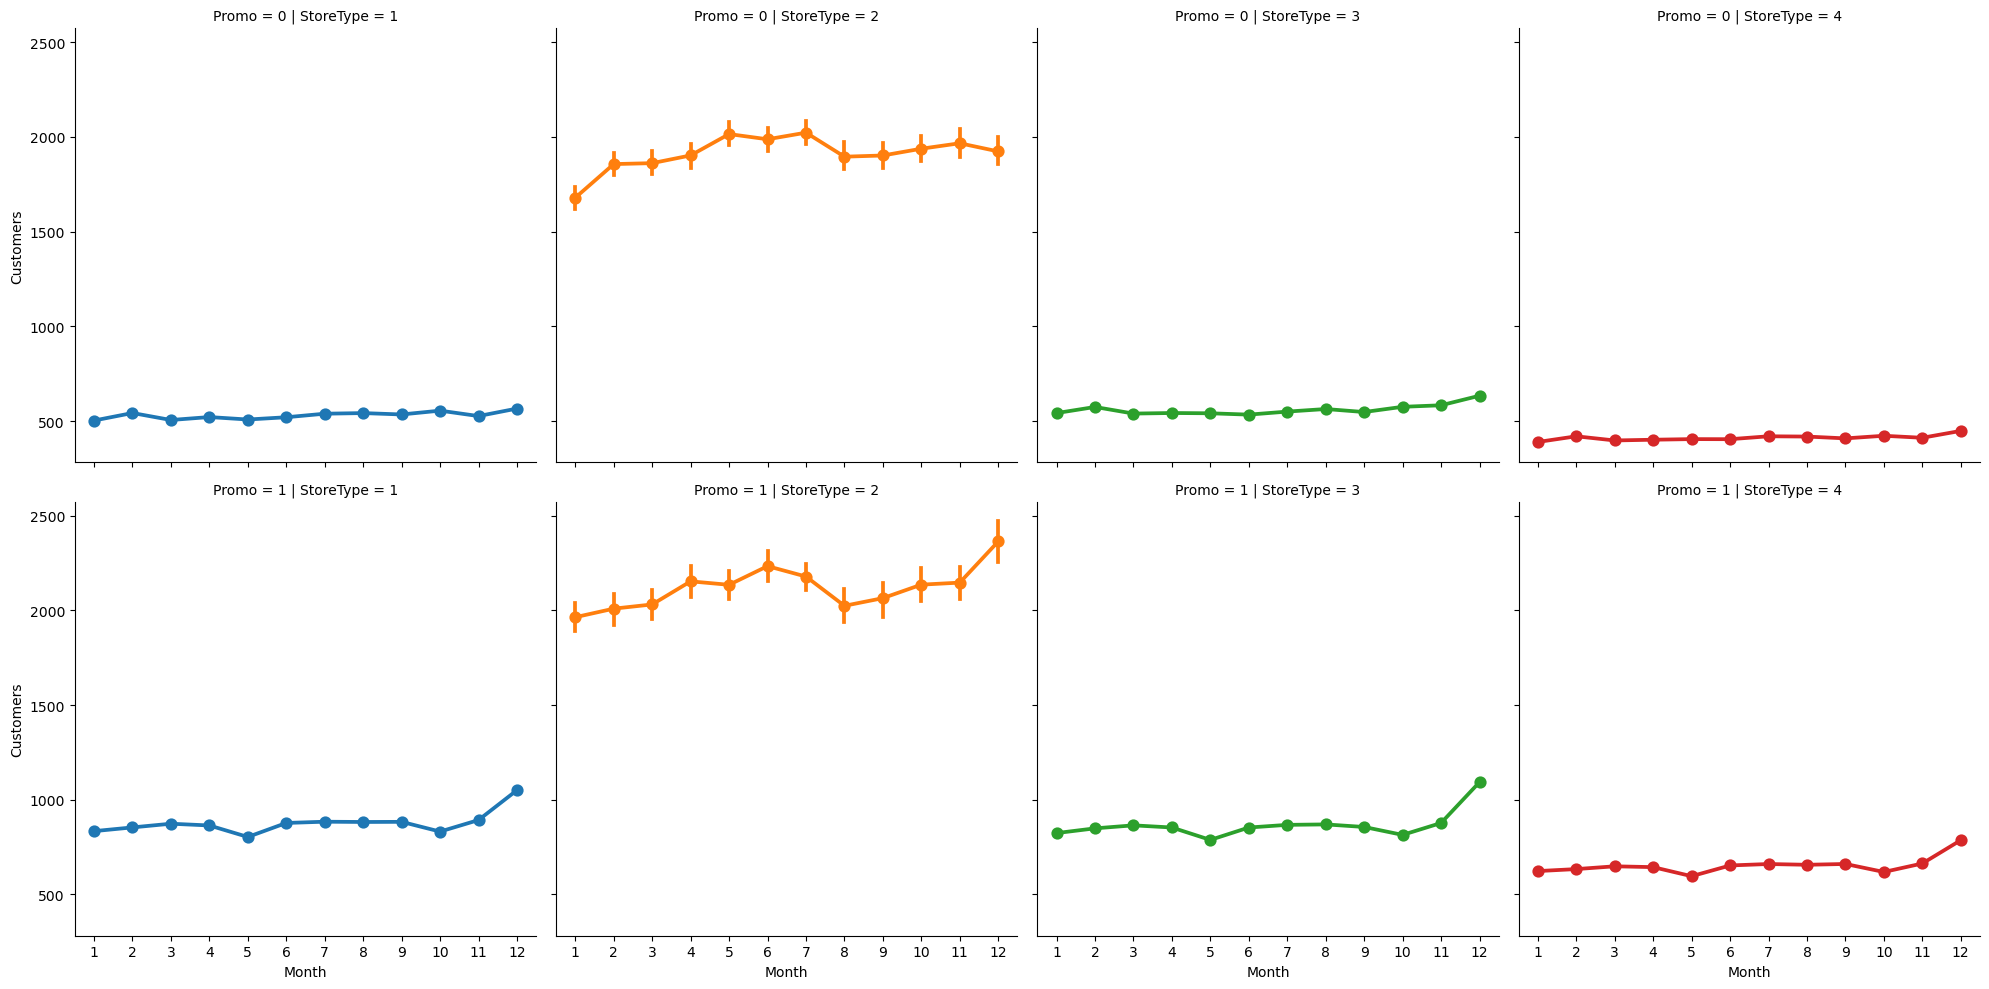

In [17]:
#customer trends against month

sns.factorplot(data = train2, x = 'Month', y = "Customers", 
col = 'StoreType', #for different store types
hue = 'StoreType',
row = 'Promo', #for different promos
) 

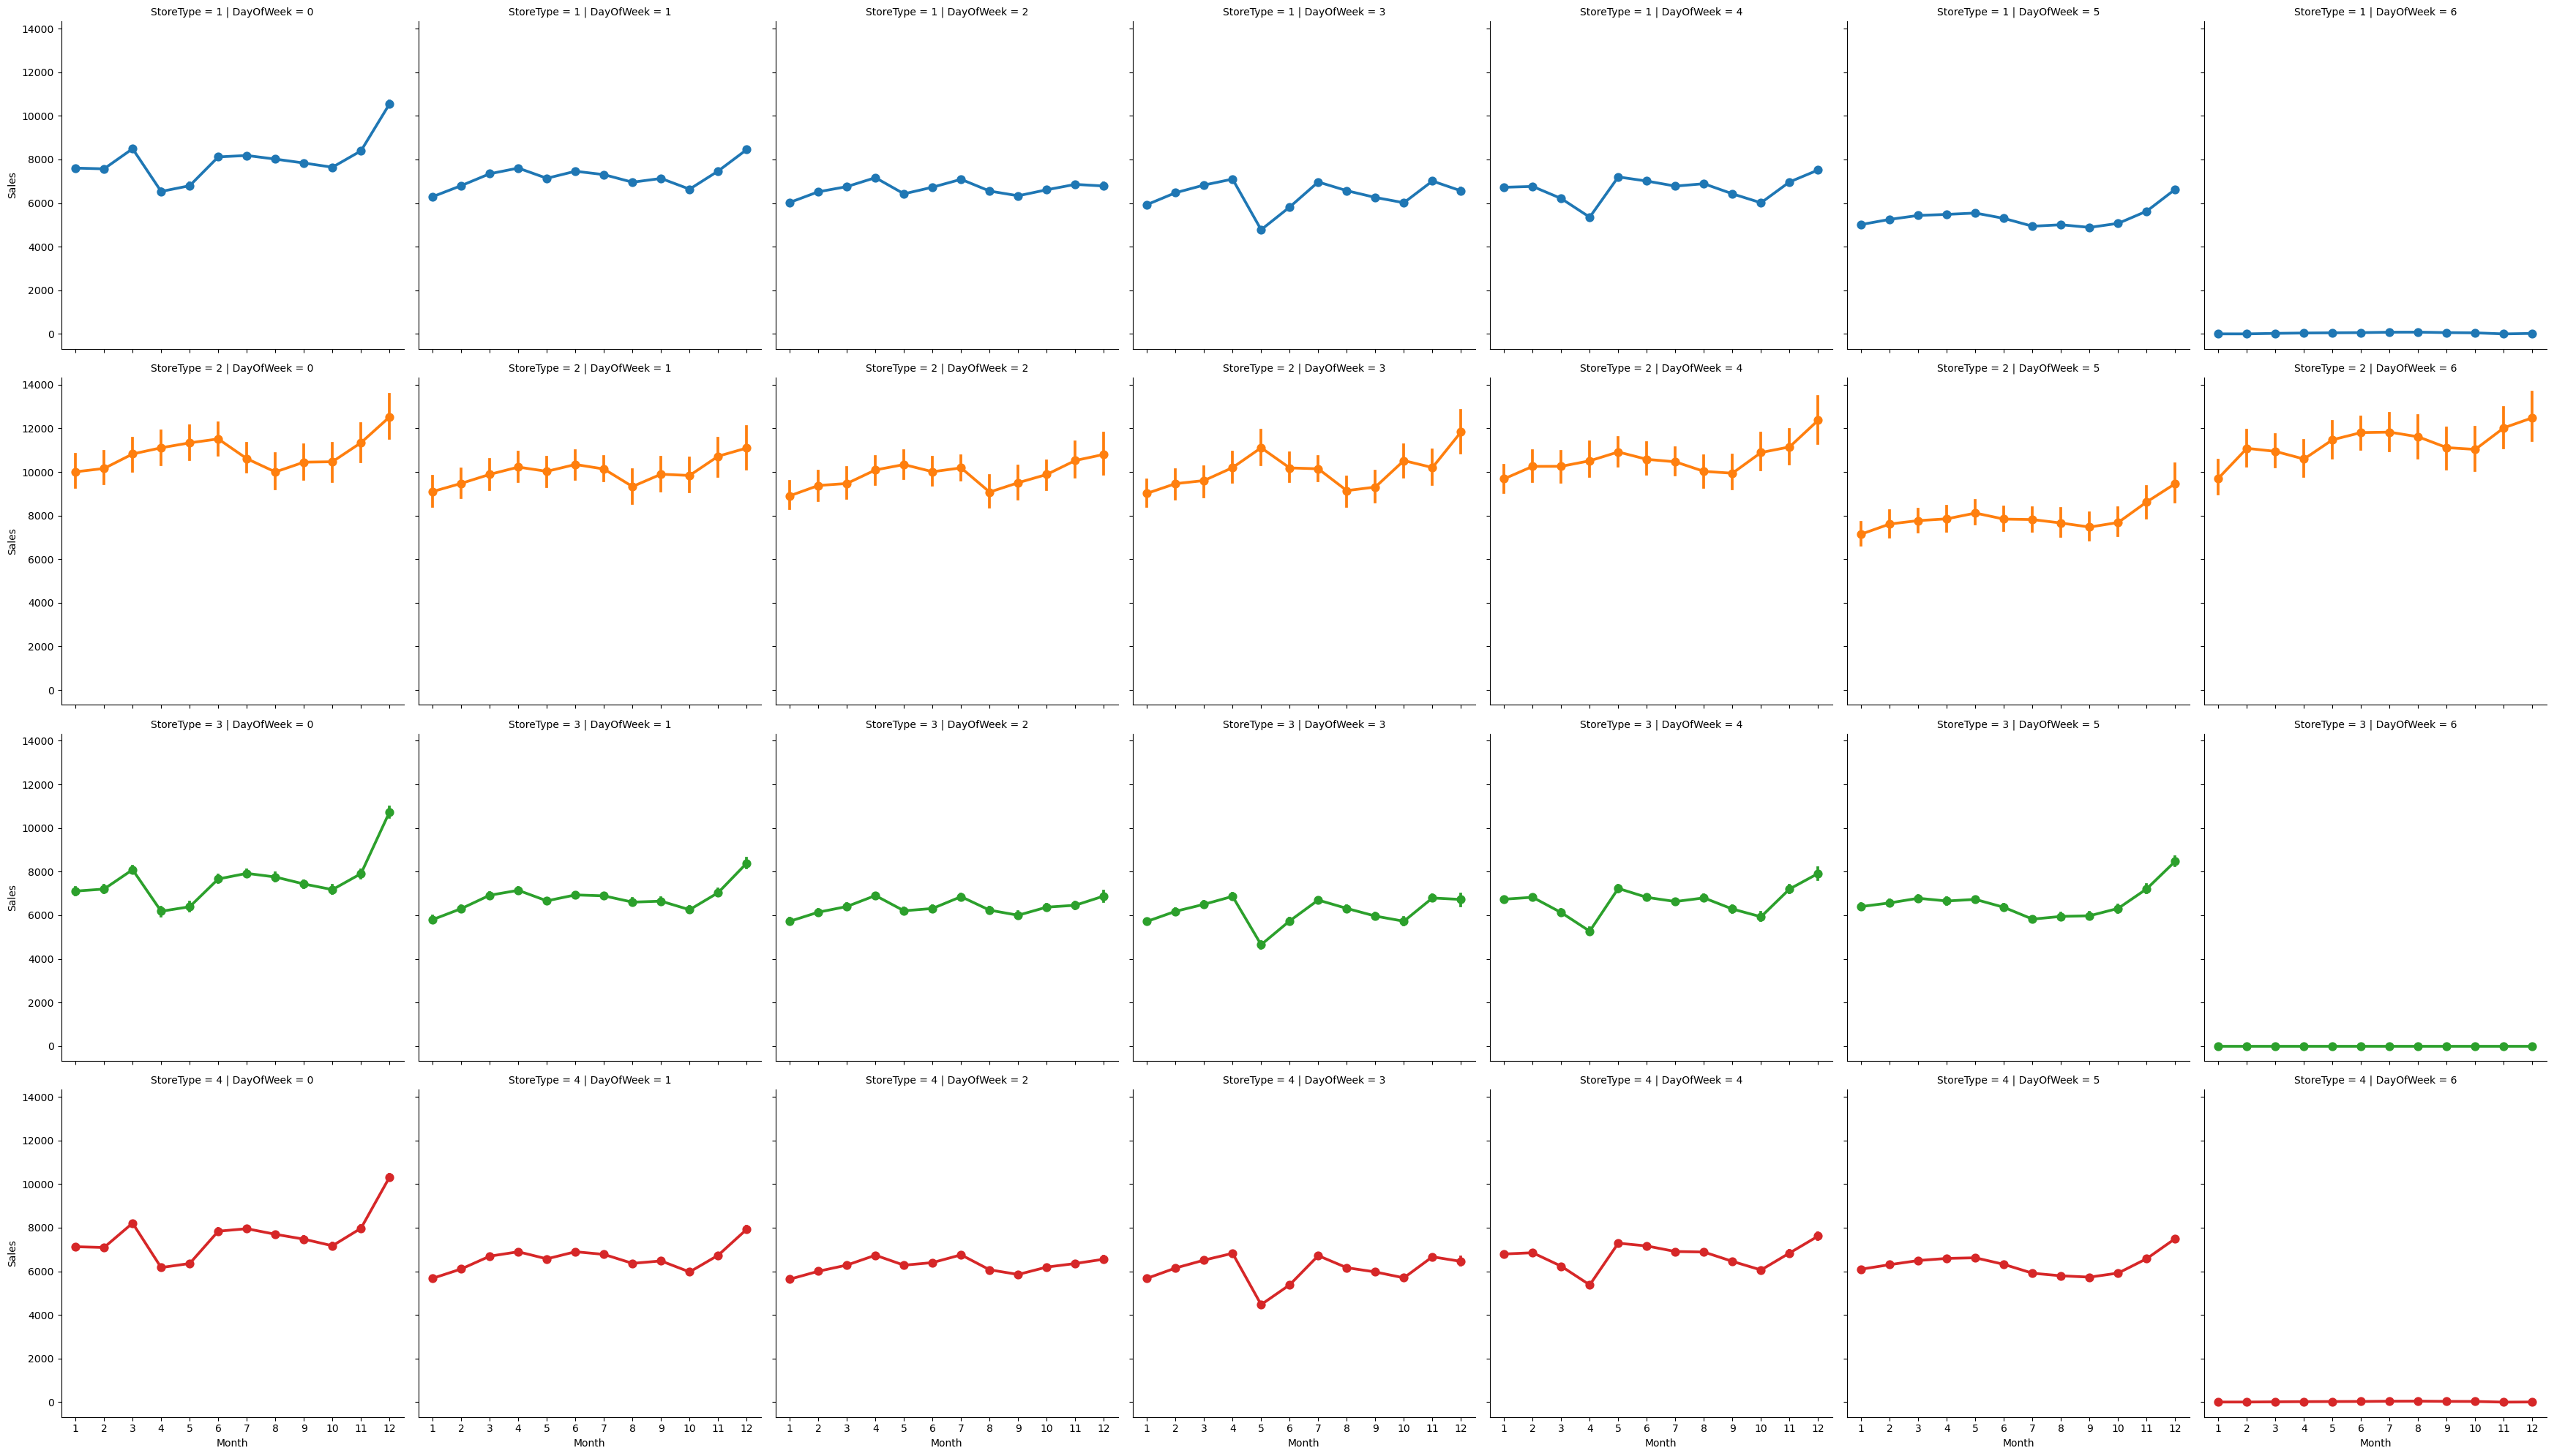

In [18]:
#sales plot for the different days of week and for different store types.

sns.factorplot(data = train2, x = 'Month', y = "Sales", 
col = 'DayOfWeek', #for different store types
hue = 'StoreType',
row = 'StoreType', #for different promos
) 

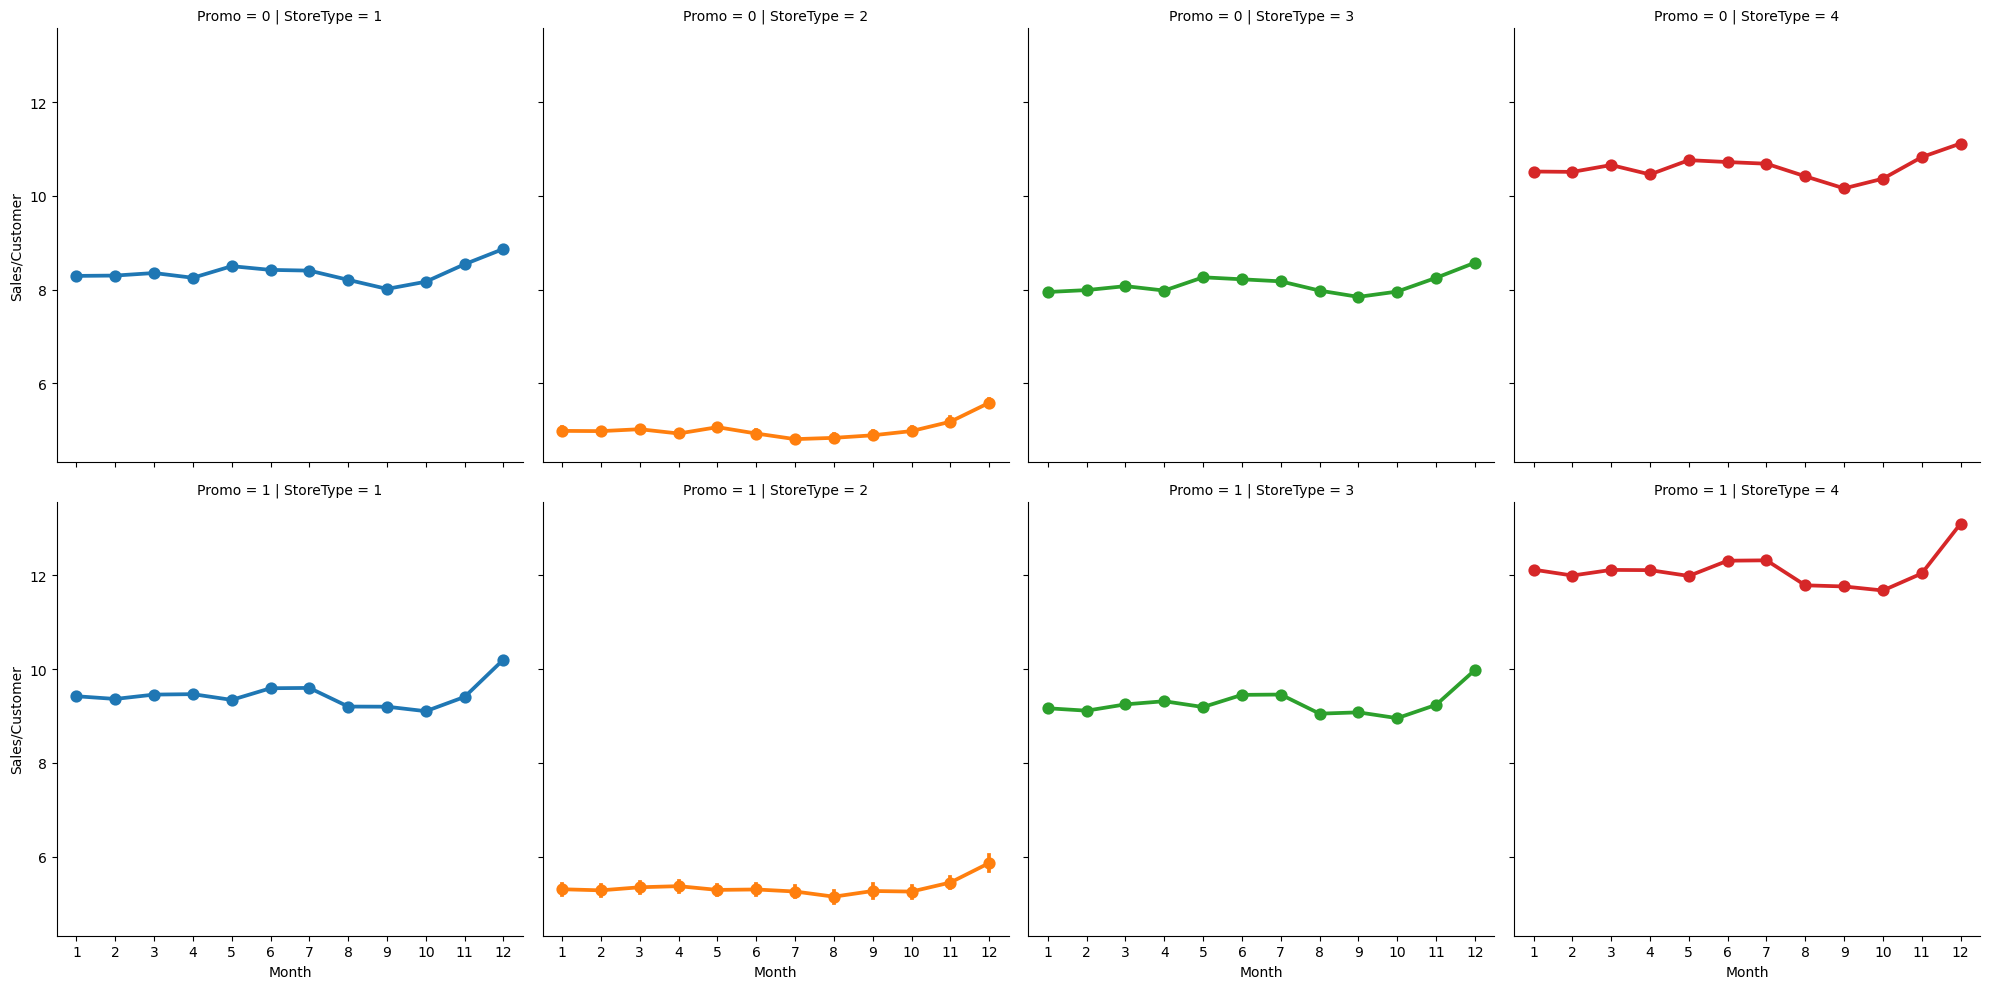

In [19]:
#sales/customer trend against month

sns.factorplot(data = train2, x = 'Month', y = "Sales/Customer", 
col = 'StoreType', #for different store types
hue = 'StoreType',
row = 'Promo', #for different promos
) 

<AxesSubplot:>

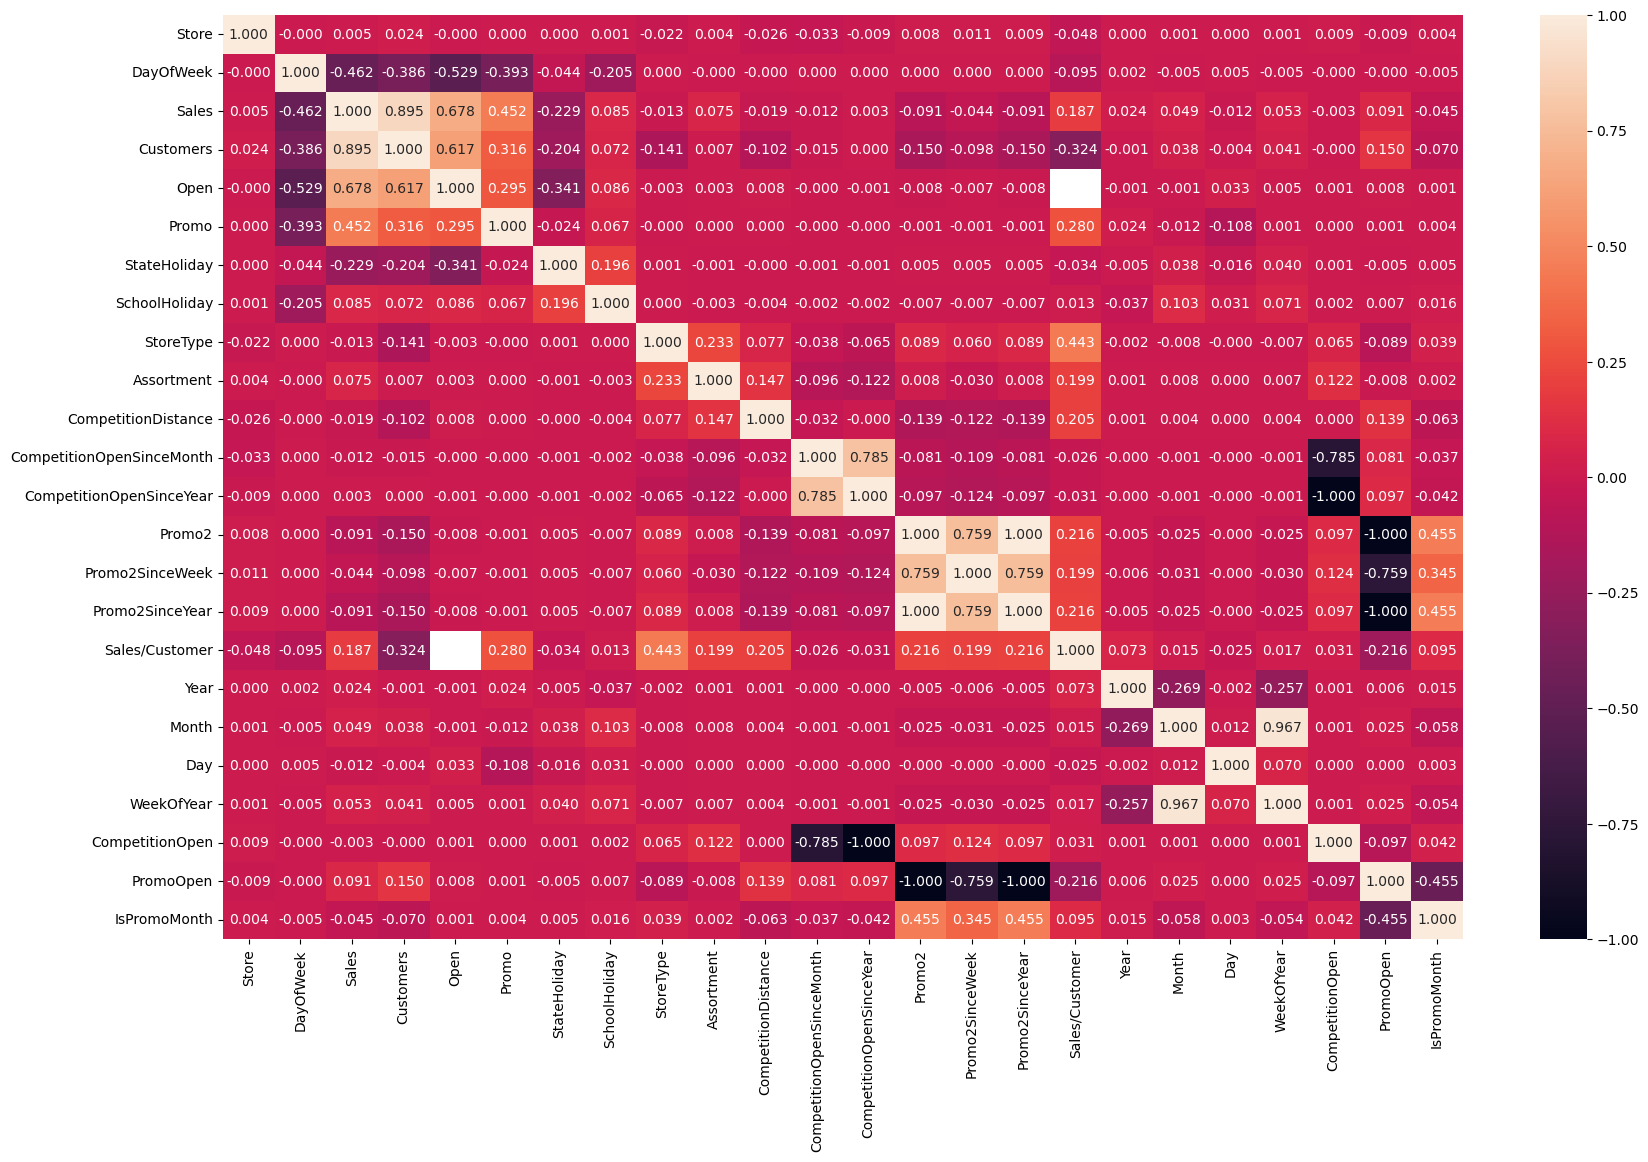

In [20]:
plt.figure(figsize = (20,12))

sns.heatmap(train2.corr(),annot = True, fmt = '.3f',vmin = -1,vmax = 1)

Now we are done with the feature creation process and by displaying the correlation plot and the heat map we can say that customers, promo, open and sales/customer are highly correlated with the sales of the stores.

Conclusion of the Exploratory Data Analysis:

1. The StoreType A has the most sales and customers value, indicating that these type of stores are the most selling and crowded.                                                                                                                         
2. The StoreType D has the maximum Sales/Customer value. This suggests that, people make large amount of bills at these stores.
3. On the other hand, even though the store type B has great sales and customer trends, but it has least value for the Sales/Customer. This may be because, the people come to these store more often, because of which their trend is higher individually, but they might not purchase is higher amounts, because of which the average value is less.
4. We can also see that for all the type of stores, highest selling is done on the first day of the week;. on Monday.
5. Store Type B shows great selling even on Sundays. However, other store types remains closed on Sunday.

Model Training for the Time Series Analysis -

Checking for the data trends, seasonalities and auto-correlation.
To check this, we will work on 4 different stores from each store type, in order to find out their data trends, seasonal trends, etc.
We will select the following store for each type-

For StoreType A, we take Store == 2.                                                                                             
For StoreType B, we take Store == 85.                                                                                           
For StoreType C, we take Store == 1.                                                                                             
For StoreType D, we take Store == 13.

In [21]:
train2 = train2.set_index('Date')

In [22]:
train2.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,3,1,...,,9.482883,2015,7,31,31,82.0,24187.75,Jul,0
2015-07-30,1,3,5020,546,1,1,0,1,3,1,...,,9.194139,2015,7,30,31,82.0,24187.75,Jul,0
2015-07-29,1,2,4782,523,1,1,0,1,3,1,...,,9.143403,2015,7,29,31,82.0,24187.75,Jul,0
2015-07-28,1,1,5011,560,1,1,0,1,3,1,...,,8.948214,2015,7,28,31,82.0,24187.75,Jul,0
2015-07-27,1,0,6102,612,1,1,0,1,3,1,...,,9.970588,2015,7,27,31,82.0,24187.75,Jul,0


In [23]:
train2['Sales'] = train2['Sales'] * 1.0

sales_a = train2[train2.Store == 2]['Sales']
sales_b = train2[train2.Store == 85]['Sales']
sales_c = train2[train2.Store == 1]['Sales']
sales_d = train2[train2.Store == 13]['Sales']

sales_a.head()

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Date'>

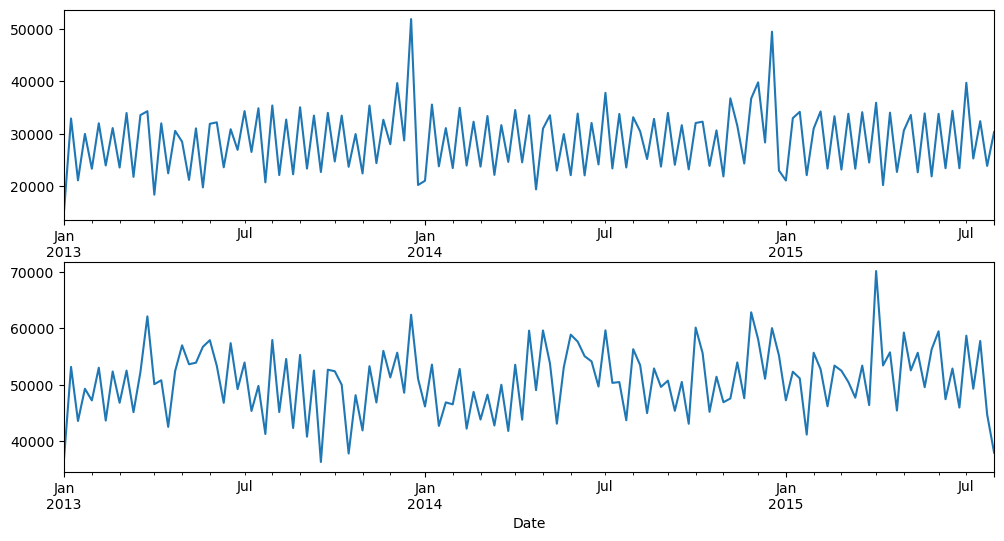

In [24]:
#f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
f, (ax1, ax2) = plt.subplots(2, figsize = (12, 6))

# store types
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
#sales_c.resample('W').sum().plot(ax = ax3)
#sales_d.resample('W').sum().plot(ax = ax4)

We can see the above graphs of the stores clubbed together on the basis of the store type.
StoreType A and C shows a peak in sales during the Christmas season.
StoreType B shows peak during Christmas and Easter too. The sales graph for StoreType D is stable most of the time, some peak is there during Christmas, but there is also no data available during the period of July 2014 to Dec 2014, as the store was closed.

Model 2 - XG Boost Model

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. Although it is not specifically designed for time-series data, it is known to perform extremely well in all kinds of regression problems.

Now we will implement the XG boost model for the same data and will generate predictions. We will also calculate the error values and will compare the error values of this model with the other models to check which model is more accurate, having less error values.

In [25]:
# Dropping Customers and Sale per customer

ts_xgboost = train2.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'Sales/Customer', 'PromoInterval','monthStr'], axis=1)
ts_xgboost.describe()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,...,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,2.998341e+00,5.773819e+03,8.301067e-01,3.815145e-01,4.516279e-02,1.786467e-01,2.207467e+00,1.935141e+00,5.415982e+03,...,5.005638e-01,1.164767e+01,1.007011e+03,2.013832e+03,5.846762e+00,1.570279e+01,2.361551e+01,7.725728e+03,1.208550e+04,1.718349e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,3.755392e-01,4.857586e-01,2.836559e-01,3.830564e-01,1.365376e+00,9.938011e-01,7.710253e+03,...,4.999999e-01,1.532393e+01,1.005877e+03,7.773960e-01,3.326097e+00,8.787638e+00,1.443338e+01,1.122712e+04,1.207292e+04,3.772371e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,1.000000e+00,3.727000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,7.000000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,1.100000e+01,2.900000e+01,2.500000e+01,0.000000e+00
50%,5.580000e+02,3.000000e+00,5.744000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.320000e+03,...,1.000000e+00,1.000000e+00,2.009000e+03,2.014000e+03,6.000000e+00,1.600000e+01,2.200000e+01,9.100000e+01,7.025000e+01,0.000000e+00
75%,8.380000e+02,5.000000e+00,7.856000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,3.000000e+00,6.880000e+03,...,1.000000e+00,2.200000e+01,2.012000e+03,2.014000e+03,8.000000e+00,2.300000e+01,3.500000e+01,2.416300e+04,2.417175e+04,0.000000e+00
max,1.115000e+03,6.000000e+00,4.155100e+04,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00,3.000000e+00,7.586000e+04,...,1.000000e+00,5.000000e+01,2.015000e+03,2.015000e+03,1.200000e+01,3.100000e+01,5.200000e+01,2.418700e+04,2.418775e+04,1.000000e+00


In [26]:
ts_xgboost.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263.0,1,1,0,1,3,1,1270.0,...,0,0.0,0.0,2015,7,31,31,82.0,24187.75,0
2015-07-30,1,3,5020.0,1,1,0,1,3,1,1270.0,...,0,0.0,0.0,2015,7,30,31,82.0,24187.75,0
2015-07-29,1,2,4782.0,1,1,0,1,3,1,1270.0,...,0,0.0,0.0,2015,7,29,31,82.0,24187.75,0
2015-07-28,1,1,5011.0,1,1,0,1,3,1,1270.0,...,0,0.0,0.0,2015,7,28,31,82.0,24187.75,0
2015-07-27,1,0,6102.0,1,1,0,1,3,1,1270.0,...,0,0.0,0.0,2015,7,27,31,82.0,24187.75,0


In [27]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1,"d":1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)
ts_xgboost.describe()

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,StateHoliday_cat,StoreType_cat,Assortment_cat
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,...,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,986159.0,0.0,0.0
mean,5.584297e+02,2.998341e+00,5.773819e+03,8.301067e-01,3.815145e-01,1.786467e-01,5.415982e+03,4.926878e+00,1.370173e+03,5.005638e-01,...,2.013832e+03,5.846762e+00,1.570279e+01,2.361551e+01,7.725728e+03,1.208550e+04,1.718349e-01,0.0,NaN,NaN
std,3.219087e+02,1.997391e+00,3.849926e+03,3.755392e-01,4.857586e-01,3.830564e-01,7.710253e+03,4.283543e+00,9.353634e+02,4.999999e-01,...,7.773960e-01,3.326097e+00,8.787638e+00,1.443338e+01,1.122712e+04,1.207292e+04,3.772371e-01,0.0,NaN,NaN
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,NaN
25%,2.800000e+02,1.000000e+00,3.727000e+03,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,...,2.013000e+03,3.000000e+00,8.000000e+00,1.100000e+01,2.900000e+01,2.500000e+01,0.000000e+00,0.0,NaN,NaN
50%,5.580000e+02,3.000000e+00,5.744000e+03,1.000000e+00,0.000000e+00,0.000000e+00,2.320000e+03,4.000000e+00,2.006000e+03,1.000000e+00,...,2.014000e+03,6.000000e+00,1.600000e+01,2.200000e+01,9.100000e+01,7.025000e+01,0.000000e+00,0.0,NaN,NaN
75%,8.380000e+02,5.000000e+00,7.856000e+03,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,...,2.014000e+03,8.000000e+00,2.300000e+01,3.500000e+01,2.416300e+04,2.417175e+04,0.000000e+00,0.0,NaN,NaN
max,1.115000e+03,6.000000e+00,4.155100e+04,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,...,2.015000e+03,1.200000e+01,3.100000e+01,5.200000e+01,2.418700e+04,2.418775e+04,1.000000e+00,0.0,NaN,NaN


In [28]:
# Splitting the data

from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Define the splitting date (change this to your desired date)
split_date = pd.to_datetime("2015-01-01")

# Filter data for training and testing based on the split date
X_train = ts_xgboost.loc[ts_xgboost.index < split_date].drop("Sales", axis=1)
y_train = ts_xgboost.loc[ts_xgboost.index < split_date]["Sales"]
X_test = ts_xgboost.loc[ts_xgboost.index >= split_date].drop("Sales", axis=1)
y_test = ts_xgboost.loc[ts_xgboost.index >= split_date]["Sales"]

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


#features = ts_xgboost.drop(["Sales"], axis = 1)
#target = ts_xgboost["Sales"]
#X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)
#X_train.shape,X_test.shape

X_train shape: (780829, 21)
y_train shape: (780829,)
X_test shape: (236380, 21)
y_test shape: (236380,)


In [29]:
# Tuning parameters - using default metrics
params = {"max_depth":6, "booster": "gbtree", "eta":0.3, "objective":"reg:linear","subsample": 0.9, "colsample_bytree": 0.7,"seed": 10}
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[17:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5480.81072	eval-rmse:5571.86118
[1]	train-rmse:4218.52644	eval-rmse:4325.53497
[2]	train-rmse:3475.16741	eval-rmse:3591.51958
[3]	train-rmse:3013.39385	eval-rmse:3108.82061
[4]	train-rmse:2720.23606	eval-rmse:2789.82523
[5]	train-rmse:2580.66435	eval-rmse:2645.95398
[6]	train-rmse:2456.11568	eval-rmse:2512.95964
[7]	train-rmse:2362.33560	eval-rmse:2415.77947
[8]	train-rmse:2326.89318	eval-rmse:2375.69498
[9]	train-rmse:2288.05680	eval-rmse:2333.50104
[10]	train-rmse:2262.64603	eval-rmse:2302.69140
[11]	train-rmse:2243.95178	eval-rmse:2283.01077
[12]	train-rmse:2193.57323	eval-rmse:2239.16478
[13]	train-rmse:2165.38712	eval-rmse:2211.77290
[14]	train-rmse:2133.49296	eval-rmse:2186.57621
[15]	train-rmse:2122.08314	eval-rmse:2178.51309
[16]	train-

In [30]:
# RMSE of model

from sklearn.metrics import mean_squared_error
rms_xgboost = np.sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1388.523316898492


Hypertuning for XGBoost                                                                                                                                                                                                                                          
Now let’s try to decrease the RMSE of XGBoost by passing different values for our hyperparameters in the XGBoost model.

eta: It defines the learning rate i.e step size to learn the data in the gradient descent modeling (the basis for XGBoost). The default value is 0.3 but we want to keep the learning rate low to avoid overfitting. So, we’ll choose 0.1 as eta.                                                                                                                                                
max_depth: Maximum depth of a tree. The default value is 6 but we want our model to be more complex and find good predictions. So, let’s choose 10 as max depth.                                                                                                                                                                                                                                          
gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. The default value is 0, let’s choose a little higher value so as to get good predictions.

In [31]:
# Tuning parameters

params_2 = {'max_depth':10, 'eta':0.1,  'gamma': 2}
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:6298.07531	eval-rmse:6408.60662
[1]	train-rmse:5751.09487	eval-rmse:5867.29652
[2]	train-rmse:5264.42143	eval-rmse:5386.69896
[3]	train-rmse:4833.15749	eval-rmse:4957.45229
[4]	train-rmse:4453.91538	eval-rmse:4582.25411
[5]	train-rmse:4116.48732	eval-rmse:4242.92724
[6]	train-rmse:3820.96738	eval-rmse:3951.13769
[7]	train-rmse:3564.36982	eval-rmse:3692.93489
[8]	train-rmse:3339.09429	eval-rmse:3464.85054
[9]	train-rmse:3145.43899	eval-rmse:3268.46206
[10]	train-rmse:2979.23648	eval-rmse:3101.76628
[11]	train-rmse:2835.19791	eval-rmse:2949.20070
[12]	train-rmse:2711.23084	eval-rmse:2826.67368
[13]	train-rmse:2602.78731	eval-rmse:2718.35359
[14]	train-rmse:2511.88500	eval-rmse:2622.81056
[15]	train-rmse:2433.80546	eval-rmse:2541.96240
[16]	train-rmse:2359.85573	eval-rmse:2468.59620
[17]	train-rmse:2288.23212	eval-rmse:2398.01306
[18]	train-rmse:2235.85864	eval-rmse:2346.16298
[19]	train-rmse:2187.34471	eval-rmse:2299.36317
[20]	train-rmse:2140.54372	eval-rmse:2253.82352
[2

In [32]:
# RMSE of model
rms_xgboost_2 = np.sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 1354.4484899676445


In [33]:
xg_p = pd.DataFrame()
xg_p["Actual Sales"] = y_test

In [34]:
xg_p["Predicted Sales"]= preds_2

In [35]:
#xg_p = xg_p.drop(xg_p[(xg_p['Actual Sales'] == 0)].index)
# Resample to calculate monthly averages
xg_p_avg = xg_p.resample('MS').mean()
xg_p_avg

,Actual Sales,Predicted Sales
Date,,
2015-01-01,5752.747866,6281.594727
2015-02-01,5710.296541,5846.567383
2015-03-01,5949.130132,5947.620117
2015-04-01,5916.857578,5854.105469
2015-05-01,5472.122002,5175.850586
2015-06-01,6199.203976,6032.577148
2015-07-01,6142.705511,6057.812500


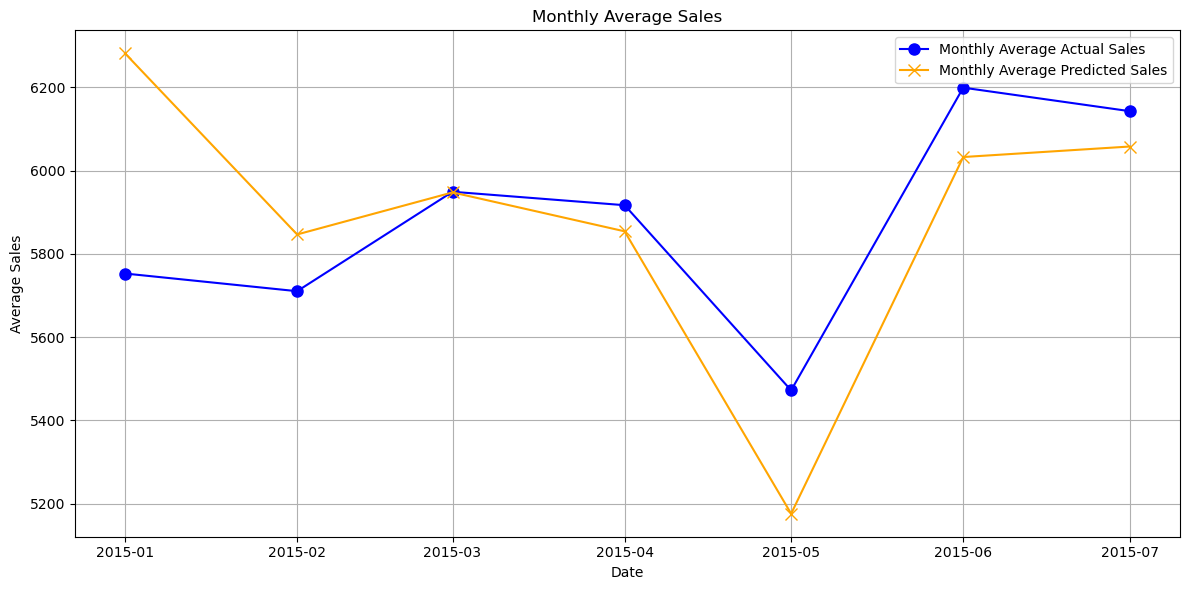

In [39]:
# Plot the monthly averages
plt.figure(figsize=(12, 6))
plt.plot(xg_p_avg.index, xg_p_avg['Actual Sales'], label='Monthly Average Actual Sales', linestyle='-', marker='o', markersize=8,color='blue')
plt.plot(xg_p_avg.index, xg_p_avg['Predicted Sales'], label='Monthly Average Predicted Sales', linestyle='-', marker='x', markersize=8,color='orange')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.title('Monthly Average Sales')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

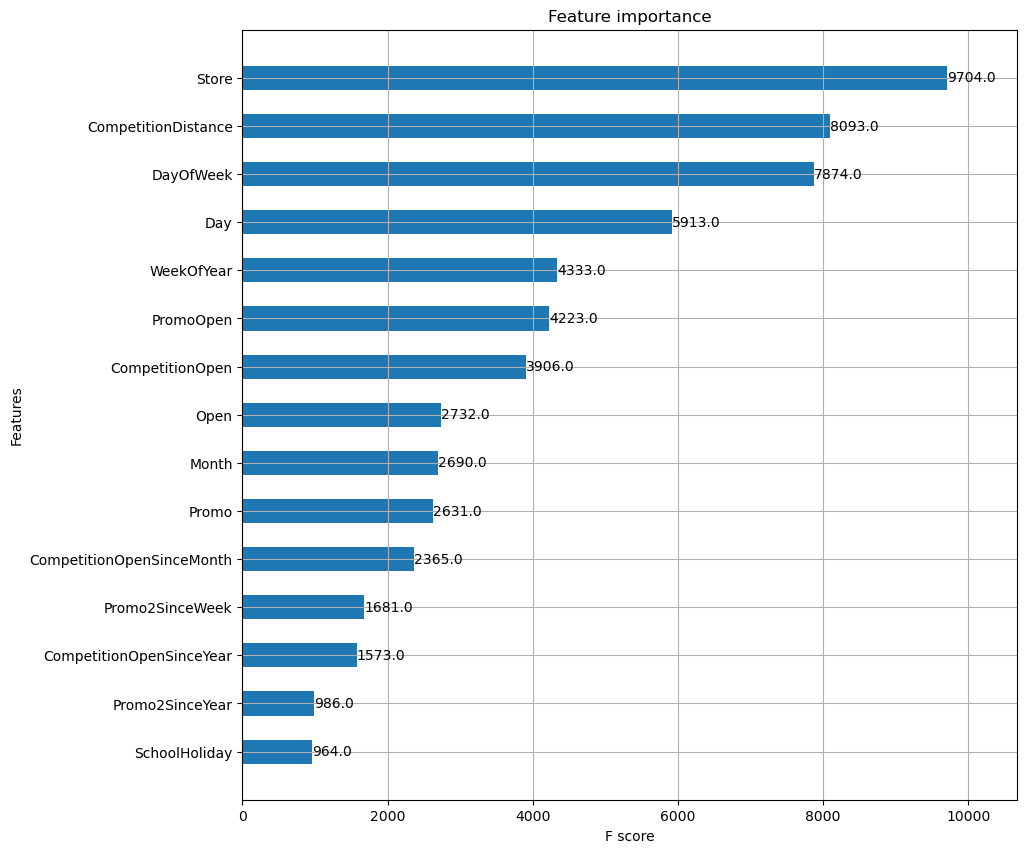

In [42]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=15, height=0.5, ax=ax)
plt.show()

As expected, there are five major reasons affecting the sales of a store viz. the number of stores, competition distance, 
day of the week, is the competition open, and promotions.                                                                                                                                                                                                                                                                                                                                      

Our final XGBoost model after hyper tuning is the one with ‘max_depth’:10, ‘eta’:0.1, ‘gamma’: 2 and RMSE score of 1354.4484899676445.